In [24]:
from pyspecter.SPECTER import SPECTER
import numpy as np


In [2]:
specter = SPECTER()

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


Compiling SPECTER model...
Generating test events for tracing ...
Test events generated! Time taken:  4.236015796661377  seconds.
Compiling spectral representation functions ...
Compilation complete! Time taken:  41.85871624946594  seconds.


# Test 1: Checking that the SEMD between an event and itself is zero!

In [3]:
# Load csv file
event = np.loadtxt("test_event.csv", delimiter=",", skiprows=1)

# Reshape to (1, 94, 3)
event = event.reshape(1, -1, 3)

emd_euc = specter.spectralEMD(event,  event)
emd_cylinder = specter.spectralEMD(event, event, metric="cylindrical")
print("Euclidean EMD: ", emd_euc)
print("Cylinder EMD: ", emd_cylinder)

Euclidean EMD:  [-4.7683716e-07]
Cylinder EMD:  [-4.7683716e-07]


# Test 2: Euclidean versus Cylindrical SEMD

In [4]:
# These particles have a distance of 2pi. On the cylinder, they are at the same position.
event1 = np.array([[0.5, 0, 0], [0.5, 0, 2 * np.pi]])
event2 = np.array([[1.0, 0, 0]])

# Add a batch dimension
event1 = event1.reshape(1, -1, 3)
event2 = event2.reshape(1, -1, 3)


emd_euc = specter.spectralEMD(event1, event2)
emd_cylinder = specter.spectralEMD(event1, event2, metric="cylindrical")
print("Euclidean EMD: ", emd_euc, ", Expected answer = (2pi)^2/2 = " + str((2 * np.pi) ** 2 / 2))
print("Cylinder EMD: ", emd_cylinder)

Euclidean EMD:  [19.73921] , Expected answer = (2pi)^2/2 = 19.739208802178716
Cylinder EMD:  [0.]


# Test 3: SEMD with non-normalized energies

The SEMD should scale with E_tot^2. We can test this by taking events with E_tot = 1, and then multipling by some constant

In [5]:
event1 = np.array([[0.5, 0, 0], [0.5, 0, 1]])
event2 = np.array([[1.0, 0, 0]])

# Add a batch dimension
event1 = event1.reshape(1, -1, 3)
event2 = event2.reshape(1, -1, 3)


emd1 = specter.spectralEMD(event1, event2)
multiplier = 3

modified_event1 = event1.copy()
modified_event1[:,:, 0] = modified_event1[:, :, 0] * multiplier
modified_event2 = event2.copy()
modified_event2[:,:, 0] = modified_event2[:, :, 0] * multiplier
emd2 = specter.spectralEMD(modified_event1, modified_event2)

print(f"Ratio of EMDs: ", emd2 / emd1, f", Expected answer = {multiplier}^2 = {multiplier**2}")

Ratio of EMDs:  [9.] , Expected answer = 3^2 = 9


# Test 4: Unabalanced events


In [6]:
omega_max = 1

# Event 1 is a single particle with energy 1
event1 = np.array([[2.0, 0, 0]])

# Event 2 is a single particle with energy 2
event2 = np.array([[1.0, 0, 0]])

# Add a batch dimension
event1 = event1.reshape(1, -1, 3)
event2 = event2.reshape(1, -1, 3)

# Calculate the EMD between the two events. THIS WILL FAIL, SINCE NO OMEGA IS PROVIDED. THIS IS EXPECTED!
try:
    emd = specter.spectralEMD(event1, event2)
except:
    print("Calculation failed since the energies are not equal. Please provide omega_max.")


# Calculate the EMD between the two events. THIS WILL WORK, SINCE OMEGA IS PROVIDED!
emd = specter.spectralEMD(event1, event2, omega_max=omega_max)
print("EMD: ", emd, ", Expected answer = (omega^2)|(e1^2 - e2^2)| = ", (omega_max)**2 * (event1[0,0,0]**2 - event2[0,0,0]**2))

Calculation failed since the energies are not equal. Please provide omega_max.
EMD:  [3.] , Expected answer = (omega^2)|(e1^2 - e2^2)| =  3.0


In [5]:
import matplotlib.pyplot as plt

Calculating EMD for omega_max = 0.001
Calculating EMD for omega_max = 0.01
Calculating EMD for omega_max = 0.1
Calculating EMD for omega_max = 1
Calculating EMD for omega_max = 10
Calculating EMD for omega_max = 100


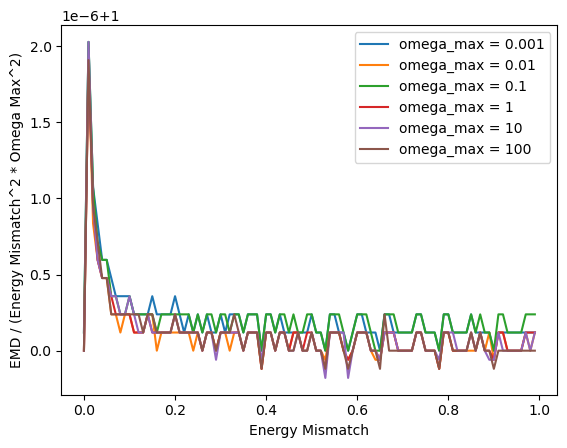

In [6]:
events1 = np.zeros((100, 1, 3))
for i in range(100):
    events1[i, 0, 0] = i / 100
    events1[i, 0, 1] = 0
    events1[i, 0, 2] = 0

events2 = np.ones((100, 1, 3)) * 1e-8


omega_maxes = [0.001, 0.01, 0.1, 1, 10, 100]
for omega_max in omega_maxes:
    print(f"Calculating EMD for omega_max = {omega_max}")
    # Set the second event to be a shifted version of the first event
    emds = specter.spectralEMD(events1, events2, omega_max=omega_max)

    energy_mismatch = np.abs(events1[:, 0, 0] - events2[:, 0, 0])

    plt.plot(events1[:, 0, 0], emds / energy_mismatch**2 / omega_max**2, label=f"omega_max = {omega_max}")

plt.xlabel("Energy Mismatch")
plt.ylabel("EMD / (Energy Mismatch^2 * Omega Max^2)")
plt.legend()
# plt.yscale("log")

In [7]:
num_events = 100
density_part = 1000

hardprocess_SEMD_data = np.array([[33.2668635 ,-0.32267319,-0.77723168],[11.61741814,1.8506712 ,-2.30852398],[5.04179647,1.18930231,-3.11217101],[0,0,0],[0,0,0]])
vacuum = np.zeros((density_part,3))
isotropics = np.zeros((num_events,density_part,3))
isotropic_hts = np.logspace(-6,3,num_events)

for i in range(num_events):
    for j in range(density_part):
        isotropics[i,j,0] = isotropic_hts[i] / density_part
        isotropics[i,j,1] = np.random.uniform(-4.9, 4.9)
        isotropics[i,j,2] = np.random.uniform(-np.pi, np.pi)

test_event = np.zeros((1000,3))
test_event[0:5,:] = hardprocess_SEMD_data

print(f'Isotropic distribution has {len(isotropics[0])} particles with hT {np.sum(isotropics[0,:,0])}')
print(f'Event has {len(np.where(hardprocess_SEMD_data[:,0] != 0)[0])} particles with hT {np.sum(hardprocess_SEMD_data[:,0])}')

print(f'SEMD between event and vacuum: {specter.spectralEMD(vacuum.reshape(1, -1, 3), test_event.reshape(1, -1, 3), omega_max = 4)}')
print(f'SEMD between event and isotropic with hT {np.sum(isotropics[0,:,0])}: {specter.spectralEMD(isotropics[0].reshape(1, -1, 3), test_event.reshape(1, -1, 3), omega_max = 4)}')

Isotropic distribution has 1000 particles with hT 9.999999999999995e-07
Event has 3 particles with hT 49.92607811
SEMD between event and vacuum: [23187.55]
SEMD between event and isotropic with hT 9.999999999999995e-07: [23187.55]


# Timing Tests

In [1]:
import time 

from pyspecter.SPECTER import SPECTER
import numpy as np

In [2]:
specter = SPECTER()


# TEST 1: Balanced EMD

num_events = 10000
events1 = np.random.normal(size=(num_events, 100, 3))
events1[:, :, 0] = 1/100


events2 = np.random.normal(size=(num_events, 100, 3))
events2[:, :, 0] = 1/100

start_time = time.time()
emds = specter.spectralEMD(events1, events2, verbose=True)
end_time = time.time()
print(f"Time taken for EMD calculation: {end_time - start_time} seconds")


# TEST 2: Unbalanced EMD

events2[:, :, 0] = 1/50  # Total Energy = 2 GeV
start_time = time.time()
emds = specter.spectralEMD(events1, events2, omega_max=1, verbose=True)
end_time = time.time()
print(f"Time taken for EMD calculation: {end_time - start_time} seconds")


No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


Compiling SPECTER model...
Generating test events for tracing ...
Test events generated! Time taken:  7.573453664779663  seconds.
Compiling spectral representation functions ...
Compilation complete! Time taken:  67.64005827903748  seconds.
Finished: Time taken: 51.55037021636963 seconds.
Time taken for EMD calculation: 51.59728932380676 seconds
Balanced events. Time taken: 34.968353033065796 seconds.
Finished: Time taken: 58.07427668571472 seconds.
Time taken for EMD calculation: 58.121225118637085 seconds


In [ ]:

# TEST 1: Balanced EMD

num_events = 10000
events1 = np.random.normal(size=(num_events, 100, 3))
events1[:, :, 0] = 1/100


events2 = np.random.normal(size=(num_events, 100, 3))
events2[:, :, 0] = 1/100

start_time = time.time()
emds = specter.spectralEMD(events1, events2, verbose=True)
end_time = time.time()
print(f"Time taken for EMD calculation: {end_time - start_time} seconds")


# TEST 2: Unbalanced EMD

events2[:, :, 0] = 1/50  # Total Energy = 2 GeV
start_time = time.time()
emds = specter.spectralEMD(events1, events2, omega_max=1, verbose=True)
end_time = time.time()
print(f"Time taken for EMD calculation: {end_time - start_time} seconds")


Finished: Time taken: 46.903419494628906 seconds.
Time taken for EMD calculation: 46.95435166358948 seconds
Balanced events. Time taken: 52.58281135559082 seconds.
Finished: Time taken: 71.91360902786255 seconds.
Time taken for EMD calculation: 71.971759557724 seconds
